In [130]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

sns.set_theme(style='darkgrid', font_scale=1.4)


# Importando datos


El archivo train.csv contiene los datos utilizados para el entrenamiento, contiene las etiquetas.
El archivo test.csv contiene los datos sin etiquetar utilizados para el concurso kaggle.

Los datos originales serán guardados aparte sin alterarse, mientras que para el analisis utilizaremos una copia
donde iremos agregando todo lo que vayamos haciendo. Esto NO quiere decir que todo lo que hagamos durante el 
análisis exploratorio será utilizado en el preprocesamiento de datos.

In [131]:
# Vamos a cargar los datos originales para guardarlos sin cambios
train_data_original = pd.read_csv('Data/train.csv')
test_data_original = pd.read_csv('Data/test.csv')

numerical_keys = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
categorical_keys = ['HomePlanet', 'Cabin', 'Destination','CryoSleep', 'VIP']

# Copia para hacer el análisis exploratorio
train_data = train_data_original.copy()
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [132]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


## Valores nulos inicialmente

Nos interesa saber como estan distribuidos los valores nulos dentro de nuestros datos para poder remplazar. Sin embargo necesitamos hacer primero
el análisis exploratorio de los datos para tener una mejór noción de como tratar los valores faltantes

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
na_count          0
dtype: int64

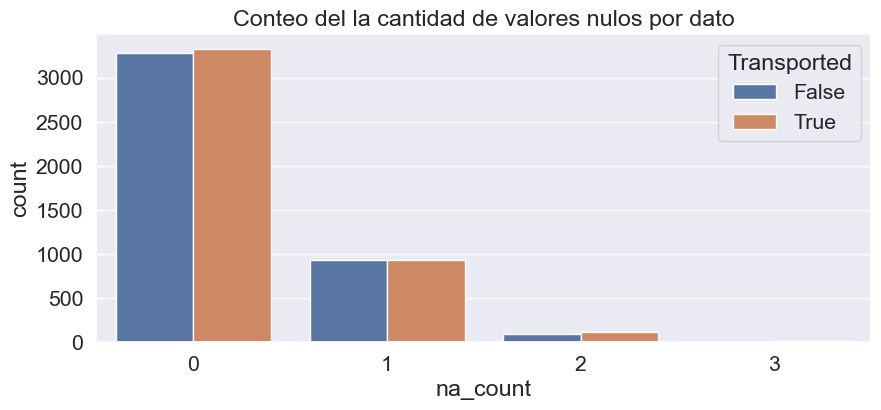

In [133]:
train_data['na_count'] = train_data.isna().sum(axis=1)
plt.figure(figsize=(10,4))
sns.countplot(data=train_data, x='na_count', hue='Transported')
plt.title('Conteo del la cantidad de valores nulos por dato')

train_data.isnull().sum()

## Analisis exploratorio

A continuación iremos con cada columna visualizando la distribución de los transportados y asi ganar conocimiento sobre los datos y 
encontrar cuales son los valores que más aportan a la clasificación. Buscamos valores con harto contraste en la cantidad de transportados.

### PasengerId
El atributo PassengerId viene dado en formato gggg_pp de donde g es el numero de grupo del pasajero y p es su numerod entro del grupo.
Podemos averiguar la distribución de tranportados a lo largo de los distintos grupos en orden.
Por otro lado podemos calcular el tamaño del grupo dentro del set de datos contando los grupos que comparten la misma id. Supondremos que el test 
se encuentra igualmente distribuido.
Otro cualidad importante es que PassengerId no cuenta con ningún elemento nulo por lo que es ideal para encontrar otros valores faltantes.

Text(0.5, 1.0, 'Transportados según si van Solo')

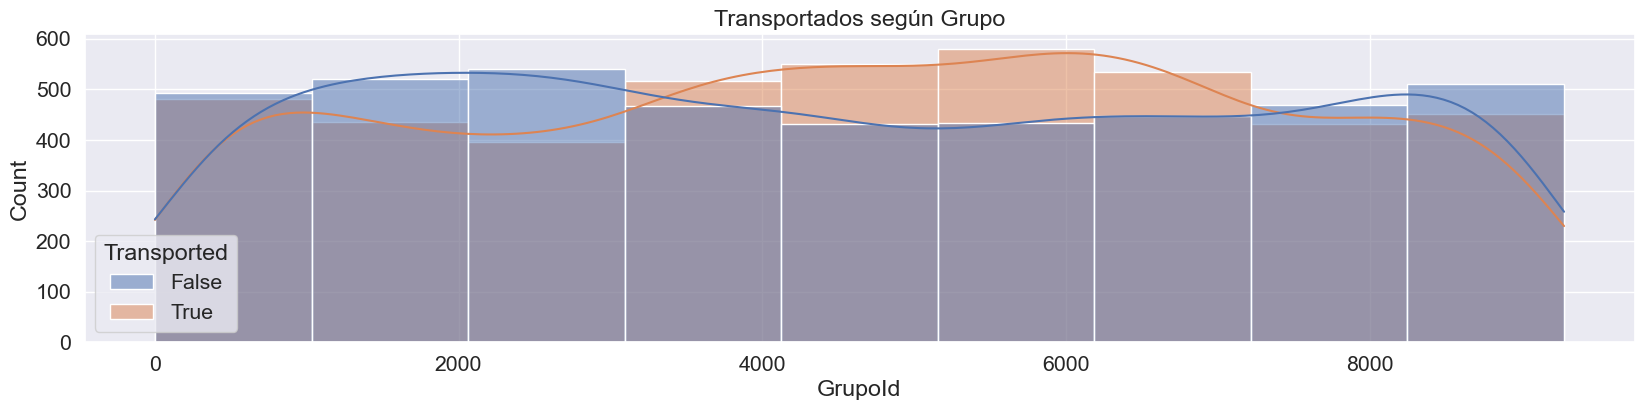

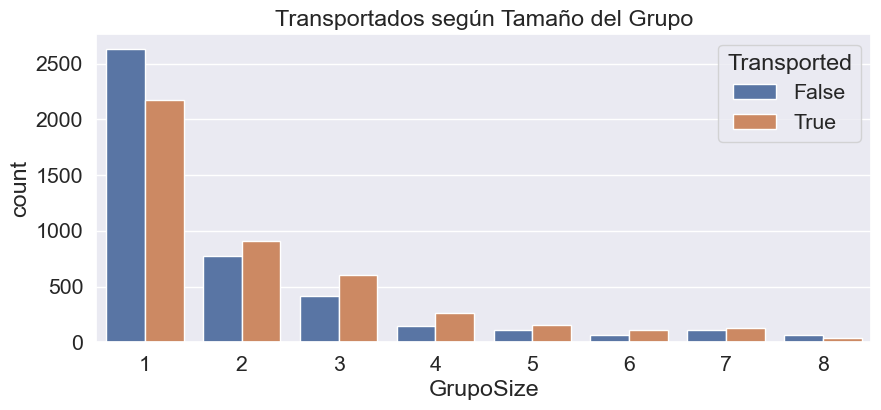

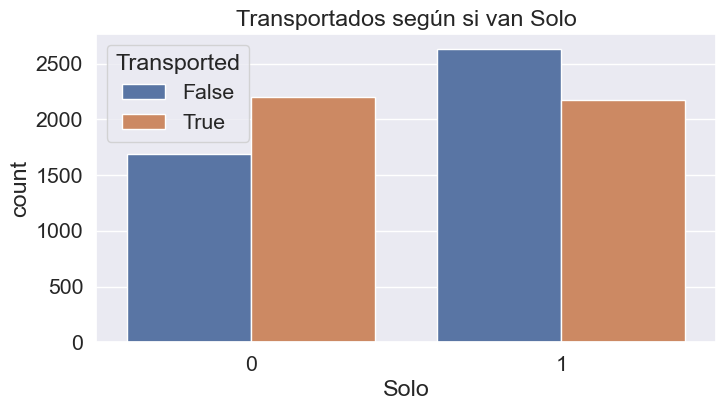

In [134]:

######################################################################################################################
datos_passengerId = pd.DataFrame()
datos_passengerId[['GrupoId','subId']] = train_data['PassengerId'].str.split('_',expand=True ).astype(int)

train_data[['GrupoId','subId']] = datos_passengerId
train_data['GrupoSize'] = datos_passengerId.groupby('GrupoId')['GrupoId'].transform('count')
train_data['Solo'] = (train_data['GrupoSize']== 1).astype(int)
######################################################################################################################
plt.figure(figsize=(20,4))
sns.histplot(data=train_data, x='GrupoId', hue='Transported', binwidth=1000, multiple='layer', kde=True)
plt.title('Transportados según Grupo')

plt.figure(figsize=(10,4))
sns.countplot(data=train_data, x='GrupoSize', hue='Transported')
plt.title('Transportados según Tamaño del Grupo')

plt.figure(figsize=(8,4))
sns.countplot(data=train_data, x='Solo', hue='Transported')
plt.title('Transportados según si van Solo')


Se puede ver que hay 3 zonas  en los grupos donde cambia la tendencia.

Tambien se puede apreciar que los grupos de un solo integrante son los menos transportados por lo que revisamos tambien la distribución
según si el pasajero se encuentra solo en su grupo.

Mas adelante intentaremos relacionar el grupoId o si va solo con algun otro valor como la cabina

### Planeta de origen y destino

Veremos como se distribuyen los transportados segun los distintos planetas de origen y segun los destinos del pasajero.

Finalmente juntaremos ambos datos agurupandolos en 6 categorias llamadas Plan de Viaje que analizaremos

En un principio los valores nulos los consideraremos como Unknown

Text(0.5, 1.0, 'Transportados segun Destino')

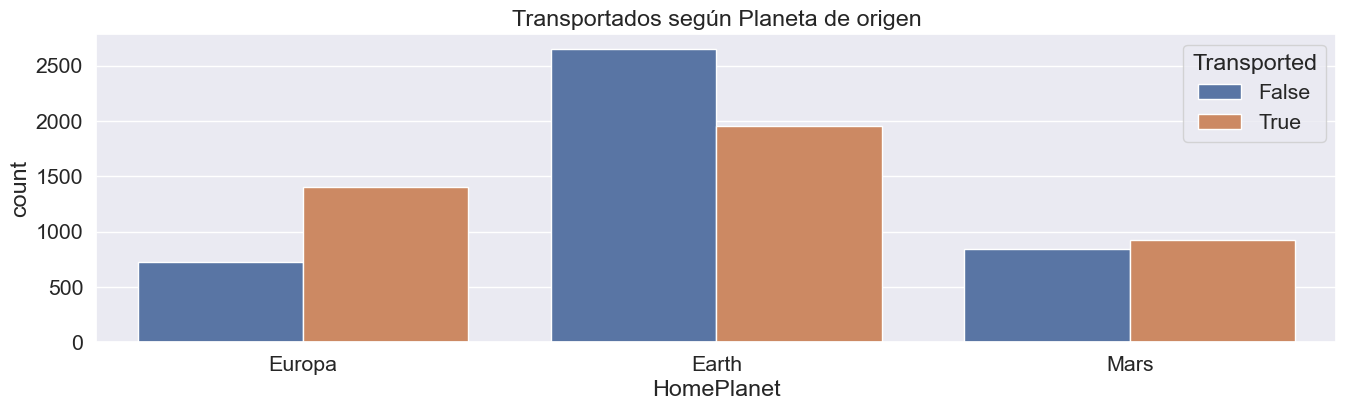

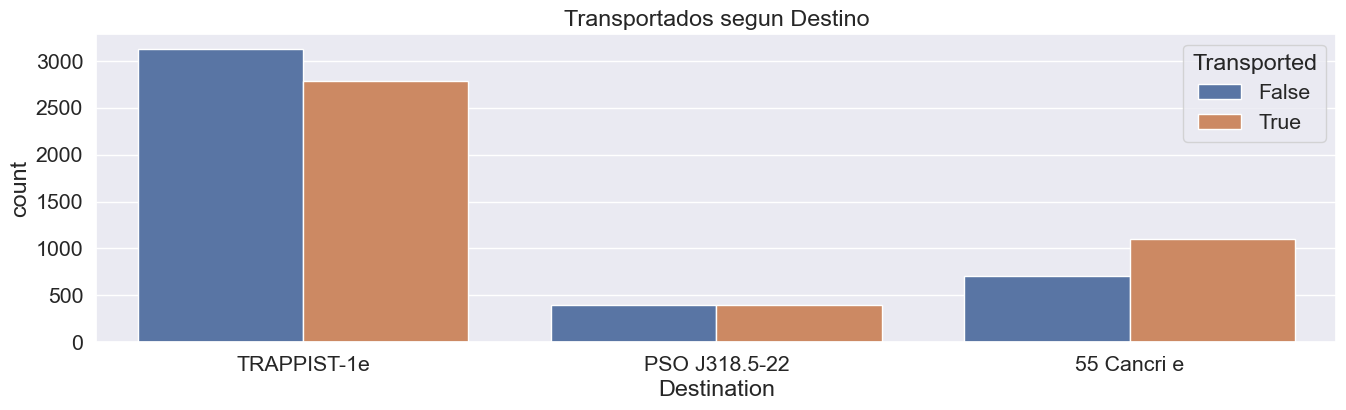

In [135]:
data_origen_destino = train_data[['HomePlanet', 'Destination', 'Transported']].copy()

#Graficar Planeta de Origen
plt.figure(figsize=(16,4))
sns.countplot(data=data_origen_destino, x='HomePlanet', hue='Transported' )
plt.title('Transportados según Planeta de origen')

#Graficar Destinos
plt.figure(figsize=(16,4))
sns.countplot(data=data_origen_destino, x='Destination', hue='Transported' )
plt.title('Transportados segun Destino')

#Calculo del pland de viaje


La mayoría de los pasajeros provienen de de la tierra y van a TRAPPIST-1e.

La informacion destino por si sola no representa mucho contraste a diferencia del planeta de origen.


Text(0.5, 1.0, 'Destino segun Planeta de origen')

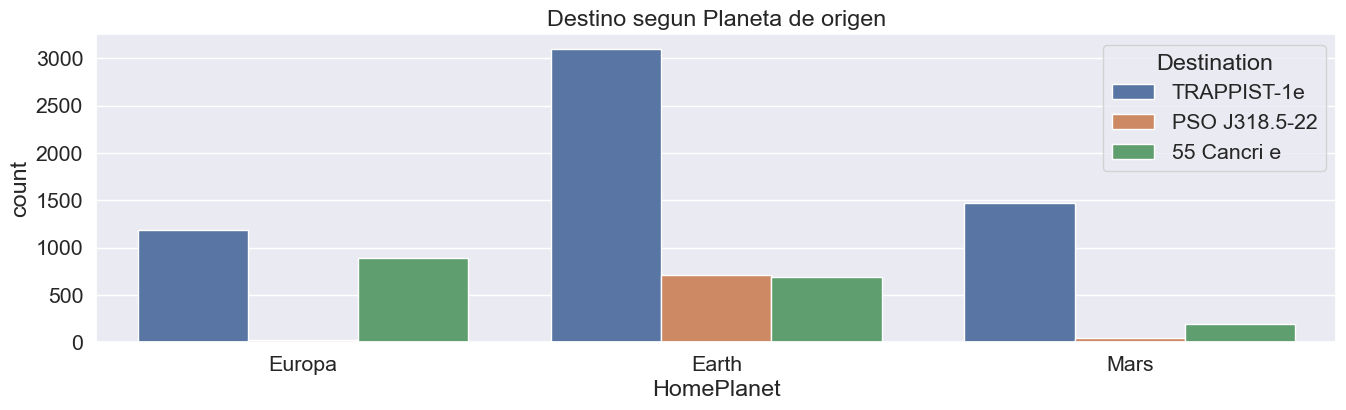

In [136]:

#Graficar distribucion de planes de viaje
plt.figure(figsize=(16,4))
sns.countplot(data=data_origen_destino, x='HomePlanet', hue='Destination' )
plt.title('Destino segun Planeta de origen')


Observaremos como se distribuyen los transportados cuando clasificamos los pasajeros segun la ruta completa o bien si vienen de la tierra, si van a trapist o ambas

Text(0.5, 1.0, 'Transportados segun si vienen de la tierra o no')

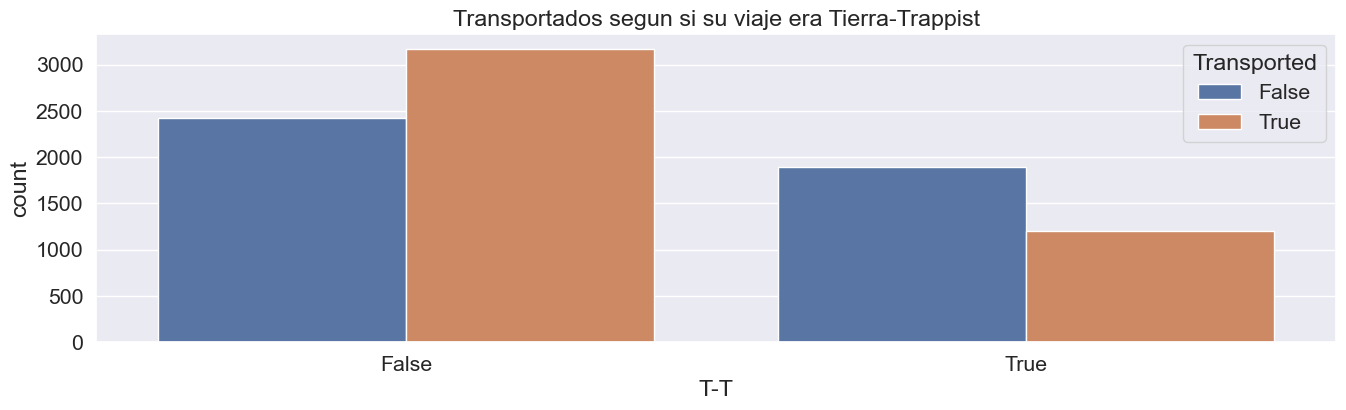

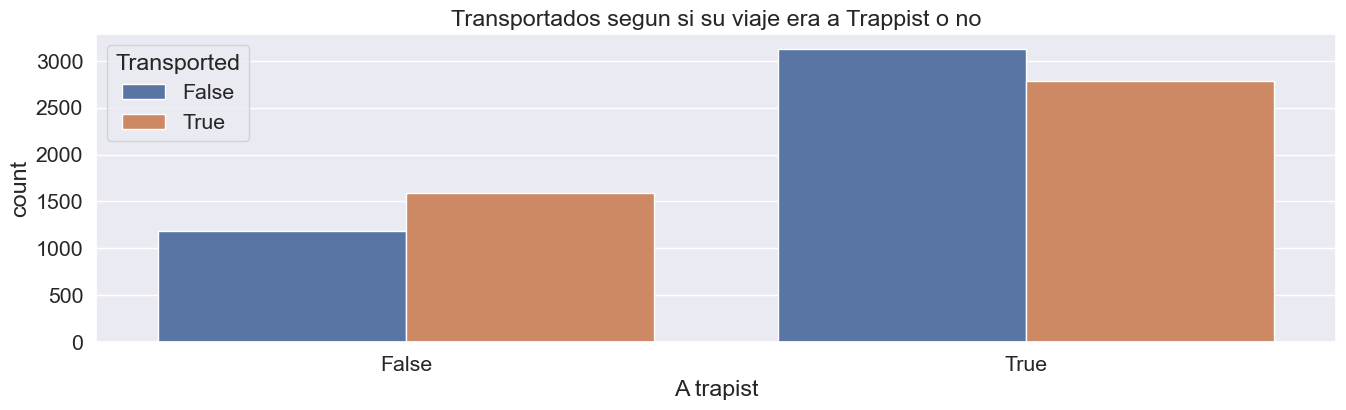

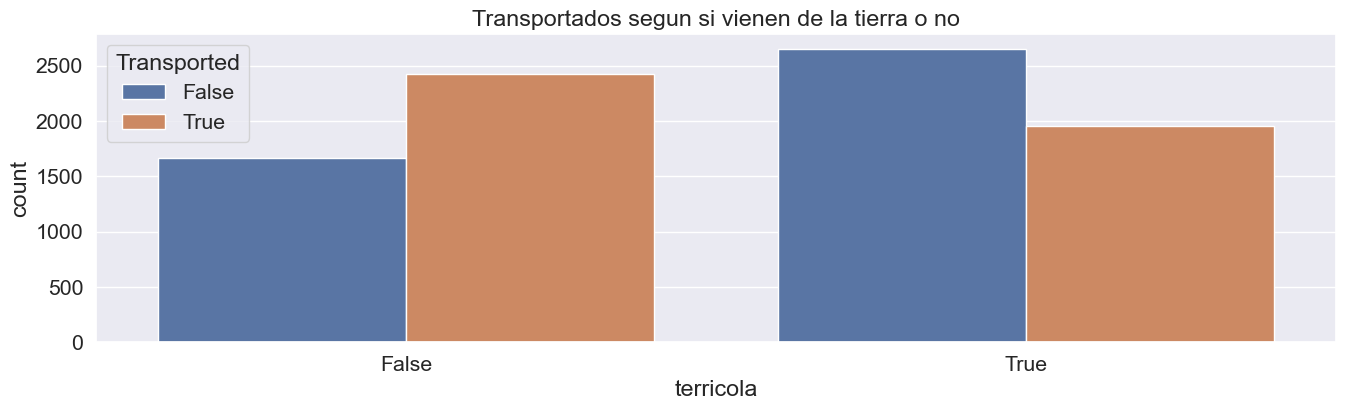

In [137]:


data_origen_destino['T-T'] = (data_origen_destino['HomePlanet'] == 'Earth') & (data_origen_destino['Destination'] == 'TRAPPIST-1e')

data_origen_destino['A trapist'] = (data_origen_destino['Destination'] == 'TRAPPIST-1e')

data_origen_destino['terricola'] = (data_origen_destino['HomePlanet'] == 'Earth')

plt.figure(figsize=(16,4))
sns.countplot(data=data_origen_destino, x='T-T', hue='Transported' )
plt.title('Transportados segun si su viaje era Tierra-Trappist')


plt.figure(figsize=(16,4))
sns.countplot(data=data_origen_destino, x='A trapist', hue='Transported' )
plt.title('Transportados segun si su viaje era a Trappist o no')

plt.figure(figsize=(16,4))
sns.countplot(data=data_origen_destino, x='terricola', hue='Transported' )
plt.title('Transportados segun si vienen de la tierra o no')

### CryoSleep

Este atributo contiene una gran cantidad de contraste en sus valores por lo que puede ser importante.
Mas adelante intetaremos relacionarlo con otros atributos como la cabina o si es vip

Text(0.5, 1.0, 'Transportados si iban en CryoSleep')

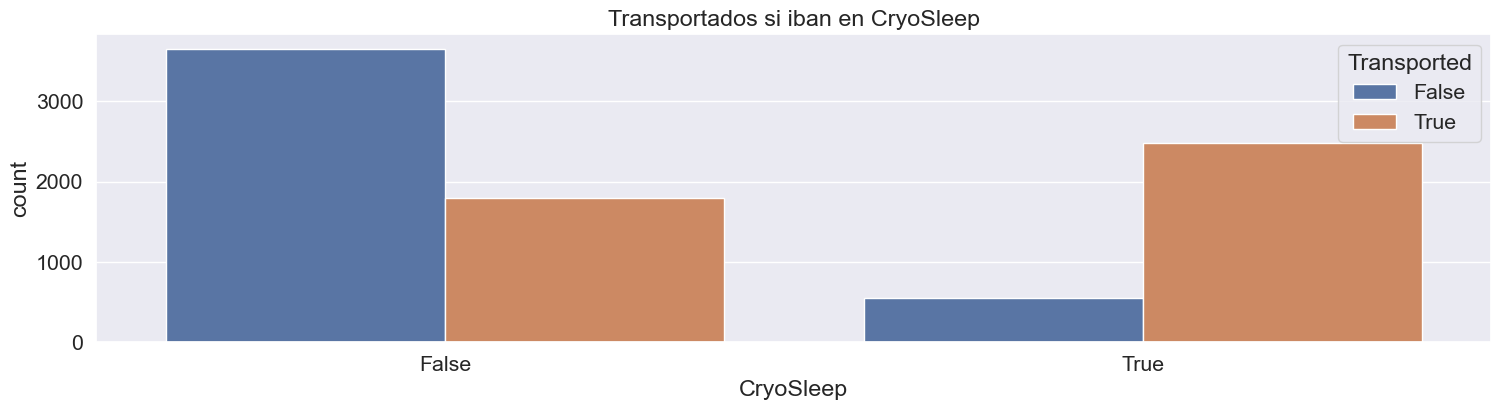

In [138]:
plt.figure(figsize=(18,4))
sns.countplot(data=train_data, x='CryoSleep', hue='Transported' )
plt.title('Transportados si iban en CryoSleep')

### VIP

En contraste, parece que vip no es un atributo determinante en el resultado final. Sin embargo puede ser util cruzarlo con alguna otra info.

Text(0.5, 1.0, 'Transportados segun VIP')

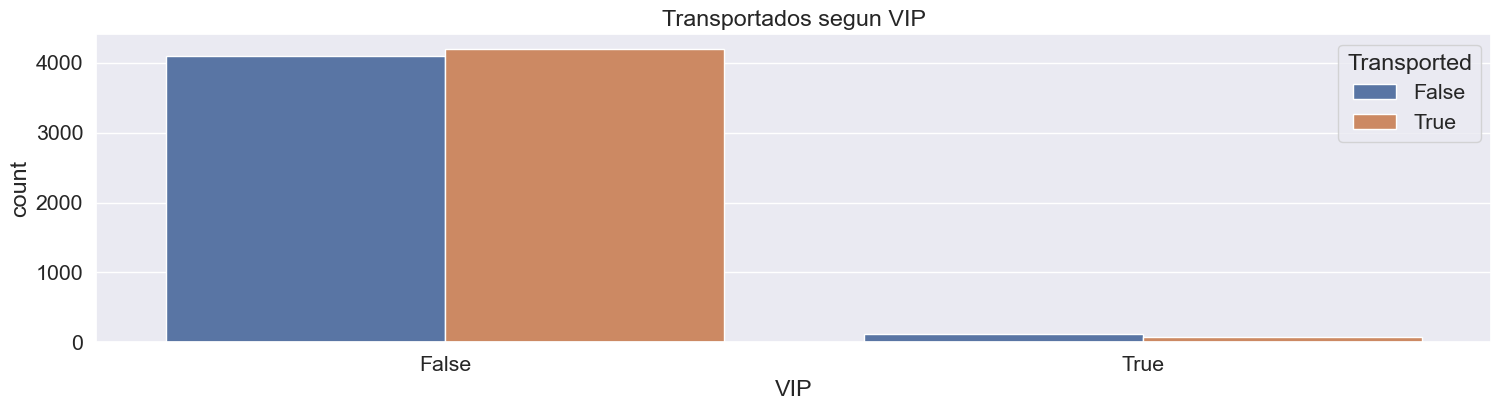

In [139]:
plt.figure(figsize=(18,4))
sns.countplot(data=train_data, x='VIP', hue='Transported' )
plt.title('Transportados segun VIP')

### Cabin  D/NN/S
La cabina viene en formato deck/num/side, es decor Cubierta, numero y lado, donde lado puede ser P de Port o S de Starboard.
Cada piso o cubierta esta designada con una letra, dentro de cada cubierta existe un numero y un lado.

Por ahora asignaremos los valores desconocidos como X/nan/X

Text(0.5, 1.0, 'Transportados segun el lado de la cabina')

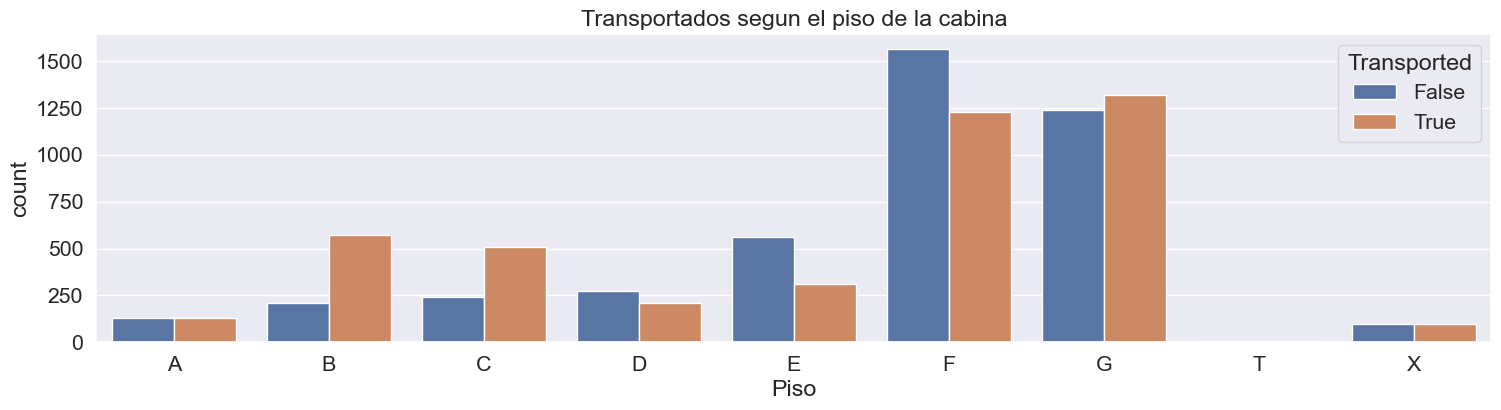

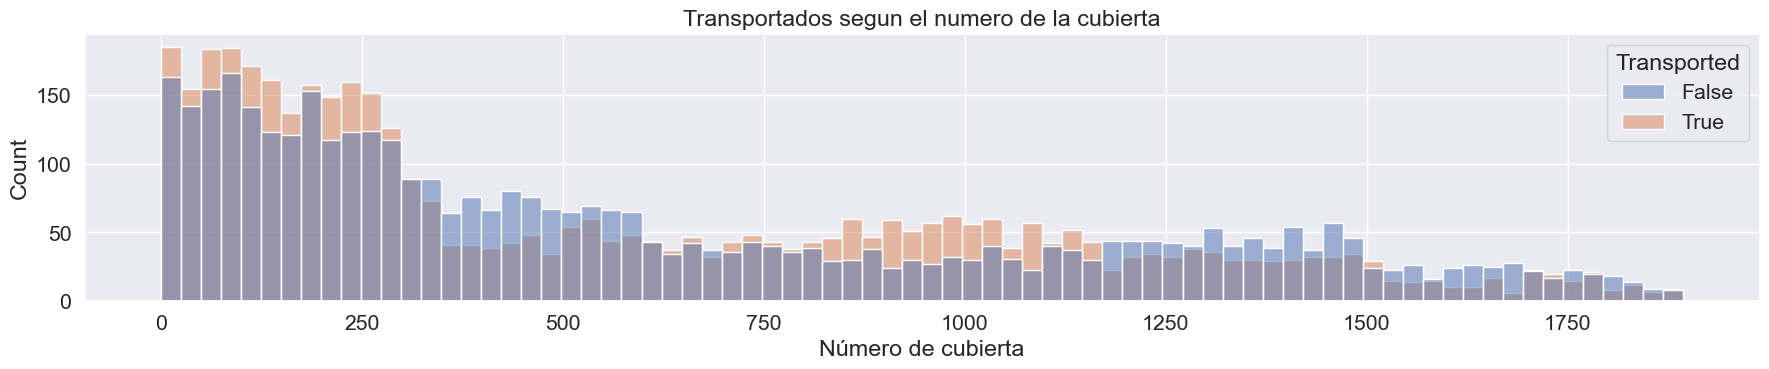

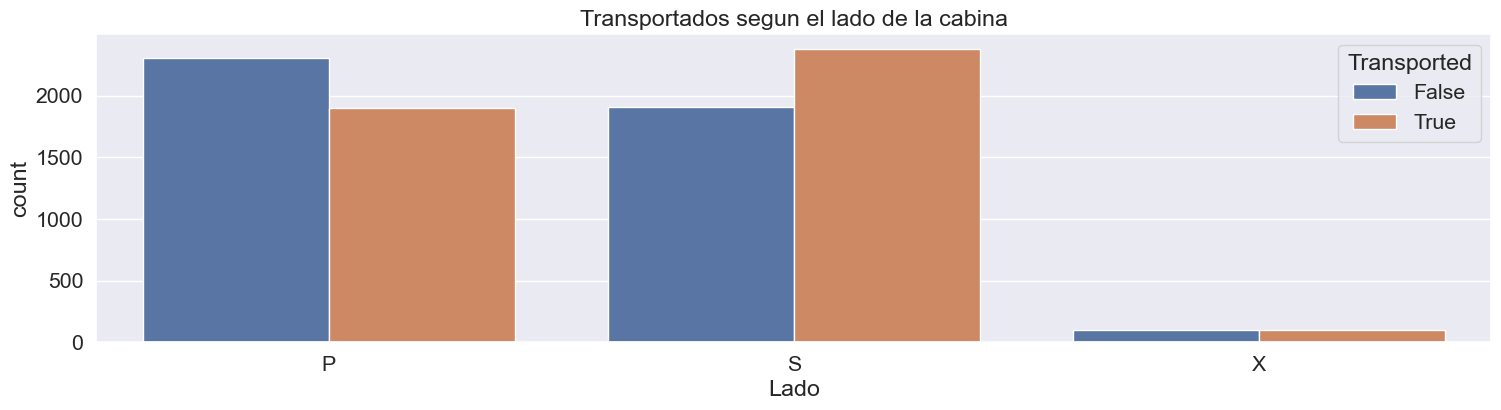

In [140]:
######################################################################################################################
data_cabina = train_data[['Cabin', 'Transported']].copy()

data_cabina['Cabin'] = data_cabina['Cabin'].fillna('X/nan/X')

data_cabina[['Piso', 'Número de cubierta', 'Lado']] = data_cabina['Cabin'].str.split('/', expand=True)
data_cabina['Número de cubierta'] = data_cabina['Número de cubierta'].astype(float)
######################################################################################################################

plt.figure(figsize=(18,4))
sns.countplot(data=data_cabina, x='Piso', hue='Transported', order=data_cabina['Piso'].sort_values())
plt.title('Transportados segun el piso de la cabina')

plt.figure(figsize=(18,4))
sns.histplot(data=data_cabina, x='Número de cubierta', hue='Transported', binwidth=25 )
#sns.histplot(data=data_cabina, x='Número de cubierta', hue='Transported', binwidth=100, fill=False )
plt.title('Transportados segun el numero de la cubierta')
plt.tight_layout()

plt.figure(figsize=(18,4))
sns.countplot(data=data_cabina, x='Lado', hue='Transported' )
plt.title('Transportados segun el lado de la cabina')

De la distribución en el piso tenemos buenos contrastes, el piso T solo tiene 5 valores, puede ser un outlier o puede corresponder a las habitaciones mas exclusivas

Por otro lado el numero de cubierta se ve separado en almenos 4 zonas, si apilamos cada 300 tendríamos 6 zonas y podriamos transformar a valores categóricos.

En el lado de la cabina tambien hay un contraste decente.

Ahora deberiamos cruzar estos valores con otros atributos. Si consideramos que la cabina es un dato que representa el lugar físico de tu cabina dentro de la nave,
esta debería estar relacionada con valores como el VIP, CryoSleep o el PassengerId, ya que pueden estar ligados a la habitacion en cuenstion. Para esto

Text(0.5, 1.0, 'Transportados segun zona')

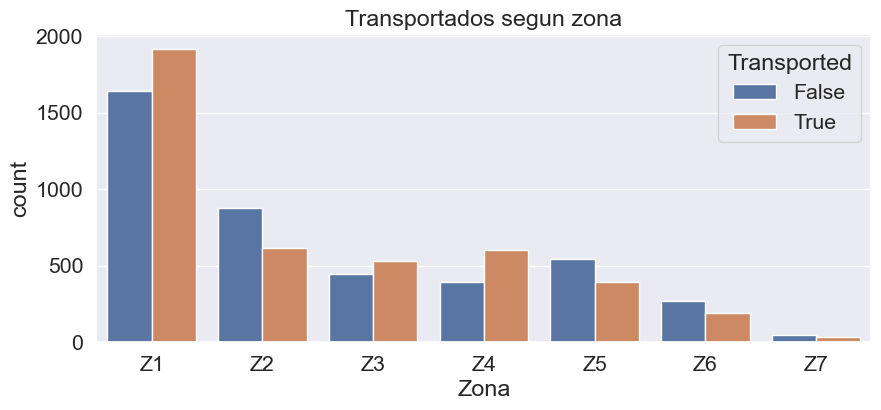

In [141]:

data_cabina.loc[ (data_cabina['Número de cubierta'] < 300), 'Zona'  ] = 'Z1'
data_cabina.loc[ (data_cabina['Número de cubierta'] >= 300) & (data_cabina['Número de cubierta'] < 600), 'Zona'  ] = 'Z2'
data_cabina.loc[ (data_cabina['Número de cubierta'] >= 600) & (data_cabina['Número de cubierta'] < 900), 'Zona'  ] = 'Z3'
data_cabina.loc[ (data_cabina['Número de cubierta'] >= 900) & (data_cabina['Número de cubierta'] < 1200), 'Zona'  ] = 'Z4'
data_cabina.loc[ (data_cabina['Número de cubierta'] >= 1200) & (data_cabina['Número de cubierta'] < 1500), 'Zona'  ] = 'Z5'
data_cabina.loc[ (data_cabina['Número de cubierta'] >= 1500) & (data_cabina['Número de cubierta'] < 1800), 'Zona'  ] = 'Z6'

data_cabina.loc[ (data_cabina['Número de cubierta'] >= 1800), 'Zona'  ] = 'Z7'
plt.figure(figsize=(10,4))
sns.countplot(data=data_cabina, x='Zona', hue='Transported',  )
plt.title('Transportados segun zona')


### Edad

La edad es conveniente transformarla a una variable categorica, podemos filtrar por rango etario para analizar la distribución

C:\Users\PC-AMD\AppData\Local\Temp\ipykernel_12840\3740318009.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Menor' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  train_data.loc[  train_data['Age'] <= 18, 'Rango etario' ] = 'Menor'


Text(0.5, 1.0, 'Transportados segun rango etario')

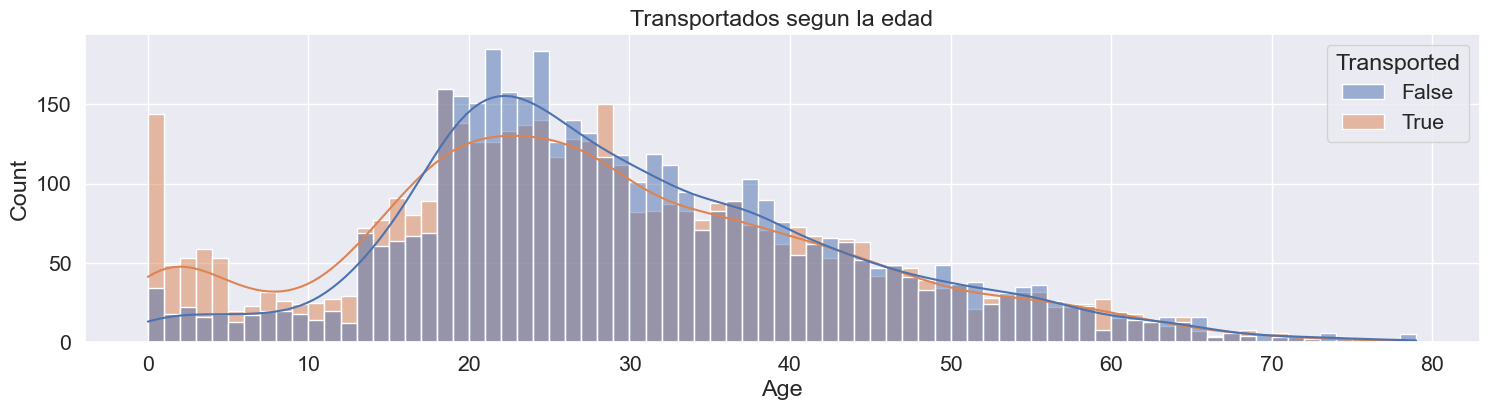

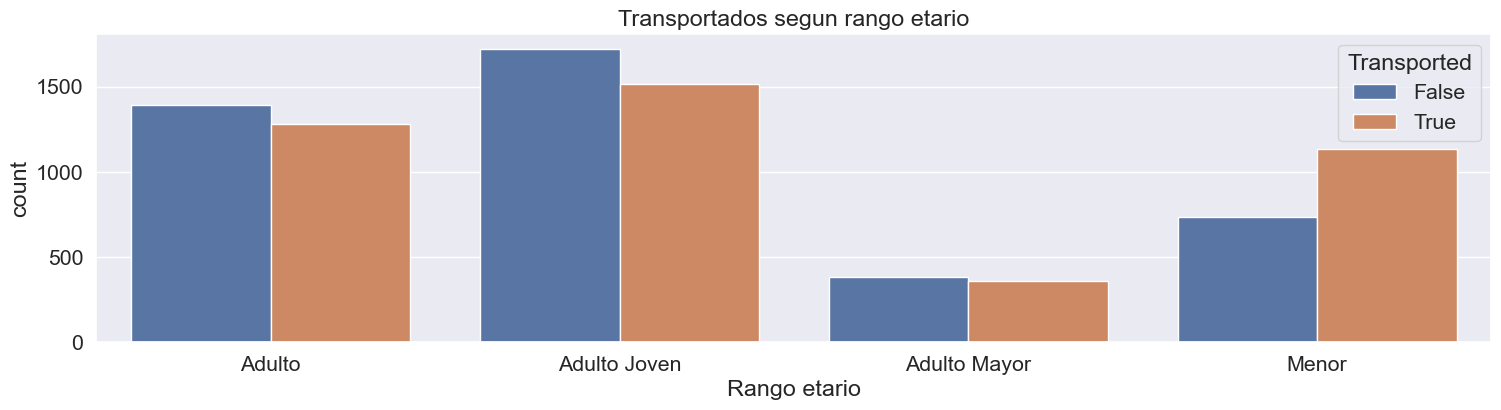

In [142]:
######################################################################################################################
train_data['Rango etario'] = np.nan
train_data.loc[  train_data['Age'] <= 18, 'Rango etario' ] = 'Menor'
train_data.loc[  (train_data['Age'] > 18) & (train_data['Age'] <= 30), 'Rango etario' ] = 'Adulto Joven'
train_data.loc[  (train_data['Age'] > 30) & (train_data['Age'] <= 50), 'Rango etario' ] = 'Adulto'
train_data.loc[  (train_data['Age'] > 50 ), 'Rango etario' ] = 'Adulto Mayor'
######################################################################################################################

plt.figure(figsize=(18,4))
sns.histplot(data=train_data, x='Age', hue='Transported', binwidth=1, kde=True)
plt.title('Transportados segun la edad')

plt.figure(figsize=(18,4))
sns.countplot(data=train_data, x='Rango etario', hue='Transported')
plt.title('Transportados segun rango etario')



# Nombre del pasajero

De aqui podriamos inferir información como la cantidad de familiares abordo


Text(0.5, 1.0, 'Numero de familiares abordo')

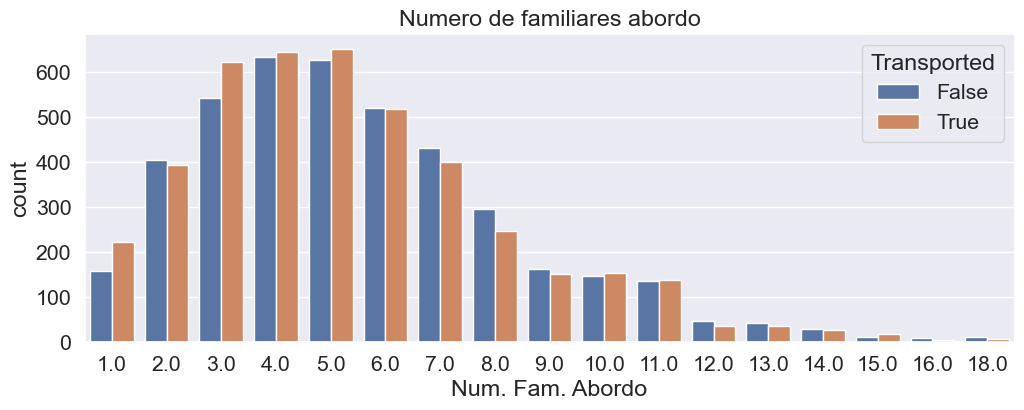

In [143]:
data_nombres = train_data[['Name', 'Transported']].copy()
data_nombres[['Nombre', 'Apellido']] = data_nombres['Name'].str.split(' ', expand=True)
apellido_count = data_nombres['Apellido'].value_counts()

data_nombres['Num. Fam. Abordo'] = data_nombres['Apellido'].map(apellido_count)

plt.figure(figsize=(12,4))
sns.countplot(data=data_nombres, x='Num. Fam. Abordo', hue='Transported')
plt.title('Numero de familiares abordo')



## Analisando los gastos del pasajero
Son 5 formas de gasto y los histogramas muestran que la mayoría de los pasajeros gastaron poco o nada de dinero en la mayoría de las opciones

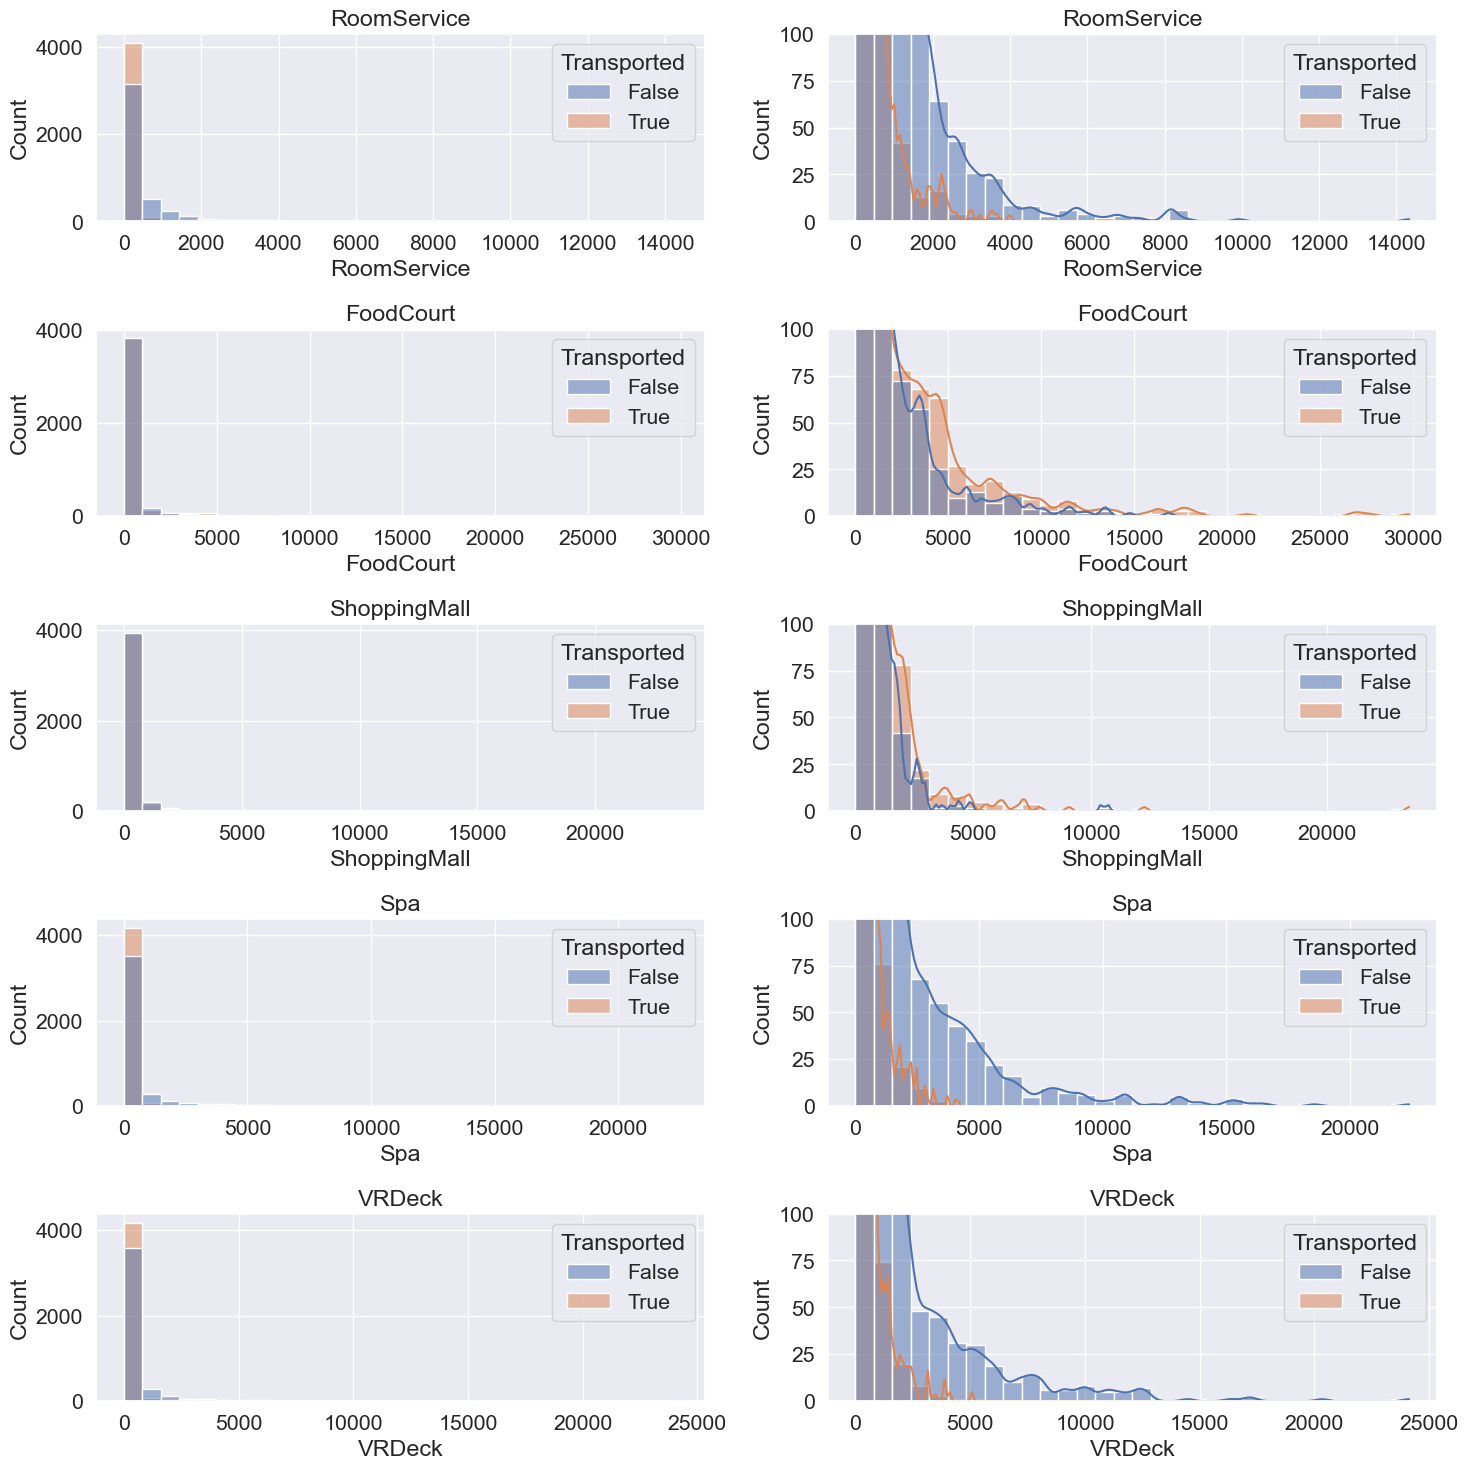

In [144]:
label_gastos = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

fig=plt.figure(figsize=(15,15))
for i, var_name in enumerate(label_gastos):
  
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=train_data, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)
    
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=train_data, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()


Si consideramos la separación entre los pasajeros que han gastado algo y los que no han gastado nada tendremos

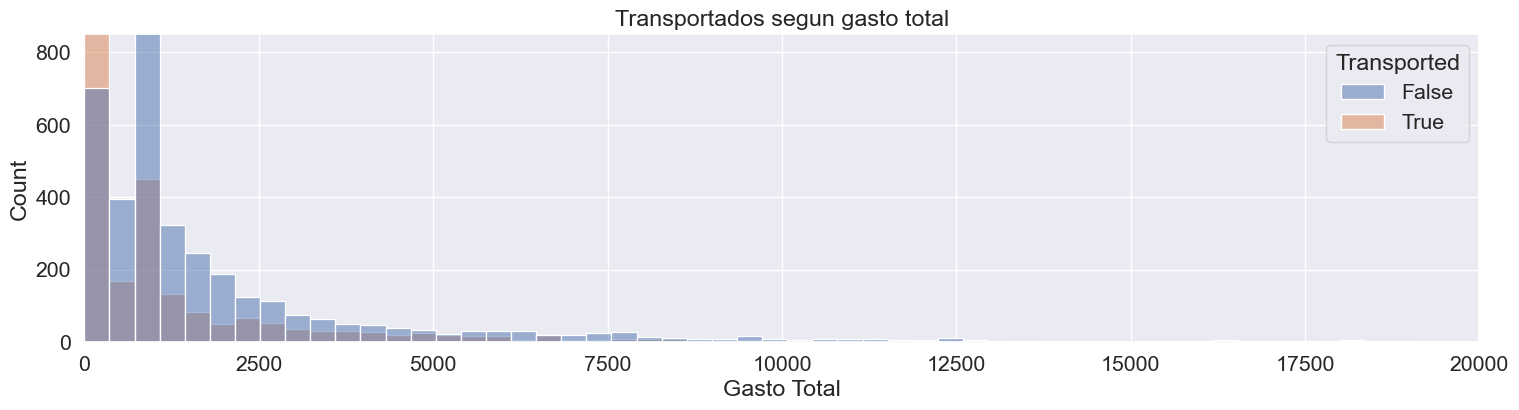

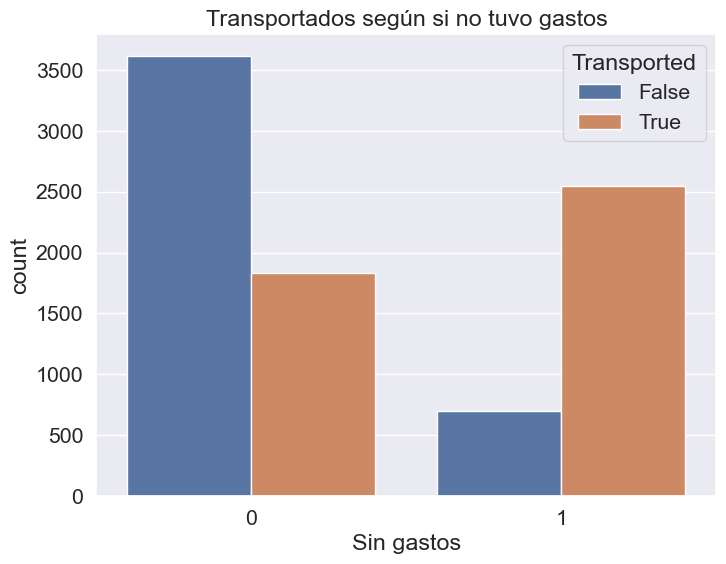

In [145]:
train_data['Gasto Total'] = train_data[label_gastos].sum(axis=1,skipna=False)
train_data['Sin gastos'] = (train_data['Gasto Total'] == 0).astype(int)

plt.figure(figsize=(18,4))
sns.histplot(data=train_data, x='Gasto Total', hue='Transported', bins=100)
plt.ylim([0,850])
plt.xlim([0,20000])
plt.title('Transportados segun gasto total')


plt.figure(figsize=(8,6))
sns.countplot(data=train_data, x='Sin gastos', hue='Transported')
plt.title('Transportados según si no tuvo gastos')
fig.tight_layout()


Esto nos entrega un gran contraste en los datos por lo que puede ser importante en la clasificaión

In [146]:
train_data.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
na_count          0
GrupoId           0
subId             0
GrupoSize         0
Solo              0
Rango etario    179
Gasto Total     908
Sin gastos        0
dtype: int64